In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Import Data

In [2]:
# training data (has survived)
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# test data
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# combined data (for imputing missing values)
comb_data = pd.concat([train_data,test_data],keys=['train', 'test'])
comb_data.head()

PassengerId  Survived  Pclass  \
train 0            1       0.0       3   
      1            2       1.0       1   
      2            3       1.0       3   
      3            4       1.0       1   
      4            5       0.0       3   

                                                      Name     Sex   Age  \
train 0                            Braund, Mr. Owen Harris    male  22.0   
      1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
      2                             Heikkinen, Miss. Laina  female  26.0   
      3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
      4                           Allen, Mr. William Henry    male  35.0   

         SibSp  Parch            Ticket     Fare Cabin Embarked  
train 0      1      0         A/5 21171   7.2500   NaN        S  
      1      1      0          PC 17599  71.2833   C85        C  
      2      0      0  STON/O2. 3101282   7.9250   NaN        S  
      3      1      0            113803  53.1000  C123        S  
      4      0      0            373450   8.0500   NaN        S

# Check for missing values

In [5]:
cols = [col for col in comb_data.columns if comb_data[col].isna().any()]
print(comb_data[cols].isna().sum())

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64


# Features
1. Calculate family size, isAlone
2. Extract titles and bin
3. Normalize fare 
4. Extract deck from cabin information
5. Fill missing fare (mean, given other information)
6. Fill missing ages (median, from other information), bin ages
7. Fill missing cabin (create seperate catergory for unknown cabin)
8. Fill missing embarked (mode, given other information?)

**1. Family size**

The fields *Parch* and *Sibsp* allow us to create a 'family size' feature and 'alone' feature. Later: We may also be able to extract a 'party size' feature from ticket and cabin info. 

In [6]:
def family_size(row):
    family_size = int(row['Parch']) + int(row['SibSp']) + 1
    isAlone = (family_size == 1)
    return family_size

comb_data['FamilySize'] = comb_data.apply(lambda row: family_size(row), axis=1)

family_map = {1: 'Alone', 2: 'Couple', 3: 'Small', 4: 'Small', 5: 'Large', 6: 'Large', 7: 'Large', 8: 'Large', 11: 'Large'}

comb_data['FamilySizeMap'] = comb_data['FamilySize'].map(lambda x: family_map[x])

print(comb_data.groupby(['FamilySize','Pclass'])['Survived'].mean())

FamilySize  Pclass
1           1         0.532110
            2         0.346154
            3         0.212963
2           1         0.728571
            2         0.529412
            3         0.350877
3           1         0.750000
            2         0.677419
            3         0.425532
4           1         0.714286
            2         0.769231
            3         0.666667
5           1         1.000000
            2         1.000000
            3         0.000000
6           1         0.500000
            2         1.000000
            3         0.000000
7           3         0.333333
8           3         0.000000
11          3         0.000000
Name: Survived, dtype: float64


**2. Extract titles and bin**

We can see the names are impeccably formatted to {Last Name}, {Title}. {Given Names} ({Actual name, if female and married}). So, there's a couple of bits of info to pull: title, and martial status

In [7]:
import re  # regex

def title_from_name(name):
    result = re.search(',\s(.*?)\.',name) # find characters between comma and space, and period. Non-greedy.
    return result.group(1)

title_freq = {}

for n in comb_data['Name']:
    if type(n) == str:
        t = title_from_name(n)
        if t:
            title_freq[t] = 1 + title_freq.get(t,0)

#print(title_freq.keys())          
#print([(k,title_freq[k]) for k in sorted(title_freq,key=title_freq.get,reverse=True)])

# from inspection
title_map = {
    'Mr': 'Mr', 
    'Mrs': 'Mrs', 
    'Miss': 'Miss', 
    'Master': 'Master', 
    'Don': 'Noble', 
    'Rev': 'Occupation', 
    'Dr': 'Occupation', 
    'Mme': 'Mrs', 
    'Ms': 'Miss', 
    'Major': 'Occupation', 
    'Lady': 'Noble', 
    'Sir': 'Noble', 
    'Mlle': 'Miss', 
    'Col': 'Occupation', 
    'Capt': 'Occupation',
    'the Countess': 'Noble', 
    'Jonkheer': 'Noble', 
    'Dona': 'Noble'
}

title_map_freq = {}
for k,v in title_map.items():
    print(k,v)
    title_map_freq[v] = title_freq[k] + title_map_freq.get(v,0)
    
print([(k,title_map_freq[k]) for k in sorted(title_map_freq,key=title_map_freq.get,reverse=True)])

comb_data['Title'] = comb_data['Name'].map(lambda x: title_from_name(x))
comb_data['TitleMap'] = comb_data['Name'].map(lambda x: title_map[title_from_name(x)])

Mr Mr
Mrs Mrs
Miss Miss
Master Master
Don Noble
Rev Occupation
Dr Occupation
Mme Mrs
Ms Miss
Major Occupation
Lady Noble
Sir Noble
Mlle Miss
Col Occupation
Capt Occupation
the Countess Noble
Jonkheer Noble
Dona Noble
[('Mr', 757), ('Miss', 264), ('Mrs', 198), ('Master', 61), ('Occupation', 23), ('Noble', 6)]


**3. Normalise fare**

Use log transformation. Could use 

Pclass  TitleMap    Sex   
1       Master      male      14.400000
        Miss        female    13.467742
        Mr          male      11.447368
        Mrs         female    12.717949
        Noble       female    12.666667
                    male      11.000000
        Occupation  female     9.000000
                    male      11.416667
2       Master      male       9.272727
        Miss        female     8.529412
        Mr          male       8.090278
        Mrs         female     8.872727
        Occupation  male       7.800000
3       Master      male       9.136364
        Miss        female     7.145695
        Mr          male       6.607710
        Mrs         female     8.046154
Name: LogFare, dtype: float64


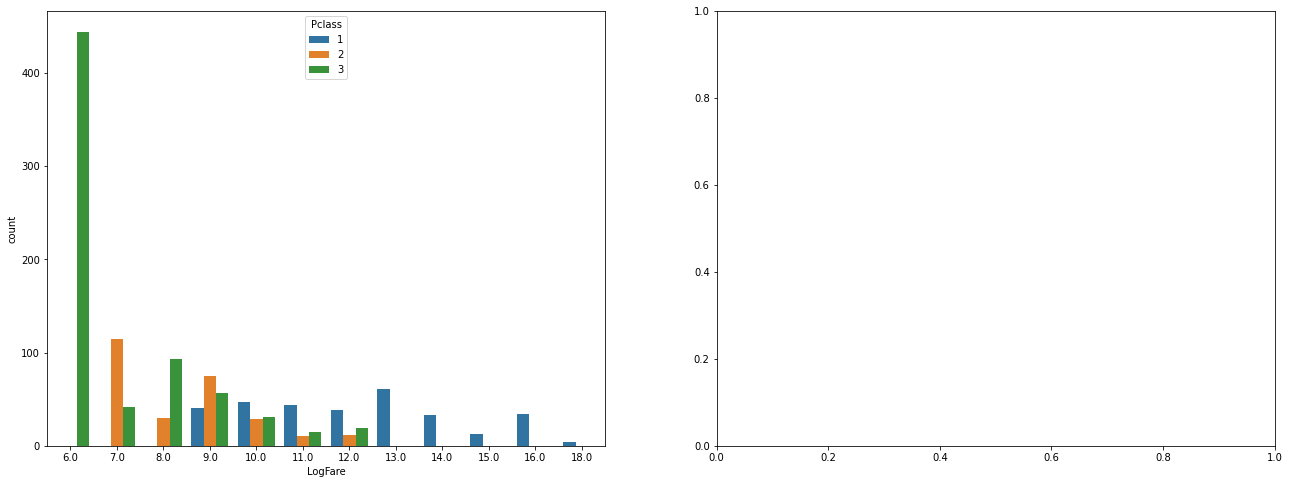

In [8]:
import math

def log_fare(x):
    try:
        norm = int(3*math.log(x+1))
        if norm < 6:
            return np.nan
        else:
            return norm
    except:
        return np.nan

comb_data['LogFare'] = comb_data['Fare'].map(lambda x: log_fare(x))

print(comb_data.groupby(['Pclass','TitleMap','Sex'])['LogFare'].mean())

import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(figsize=(22,8), nrows = 1, ncols = 2)
ax = sns.countplot(x ='LogFare', hue='Pclass', data = comb_data, ax = axes[0])

**4. Extract deck from cabin info**

First letter is the deck

In [9]:
# first letter is the deck
def extract_deck(s):
    try:
        return s[0]
    except:
        return ''

comb_data['Deck'] = comb_data['Cabin'].map(lambda x: extract_deck(x))

deck_map = {'A': 'ABC','B': 'ABC','C': 'ABC','D': 'D', 'E': 'E', 'F':'F', 'G':'GT', 'T':'GT'}

def map_deck(s):
    if s:
        return deck_map[s]
    else:
        return 'unknown'
    
comb_data['DeckMap'] = comb_data['Deck'].map(lambda x: map_deck(x))

**5. Fill missing fare**

Details: 3rd class, alone, male, 60 years old, embarked at S... The most significant of those is the class, so value should probably be around the mean for 3rd Class fares. Check the difference with the other info.

In [10]:
comb_data['LogFare'] = comb_data.groupby(['Pclass','Sex','TitleMap','FamilySizeMap'])['LogFare'].apply(lambda x: x.fillna(x.median()))

**6. Fill missing ages**

Based it on class, gender, title, family size

In [11]:
print(comb_data.groupby(['Pclass','Sex','TitleMap','FamilySizeMap'])['Age'].median())
comb_data['Age'] = comb_data.groupby(['Pclass','Sex','TitleMap','FamilySizeMap'])['Age'].apply(lambda x: x.fillna(x.median()))

if comb_data['Age'].isna().any():
    comb_data['Age'] = comb_data.groupby(['Pclass','Sex','TitleMap'])['Age'].apply(lambda x: x.fillna(x.median()))
    
print(comb_data['Age'].isna().any())

comb_data['AgeBin'] = pd.cut(comb_data['Age'], bins=15, labels=None)

Pclass  Sex     TitleMap    FamilySizeMap
1       female  Miss        Alone            32.00
                            Couple           22.00
                            Large            23.00
                            Small            20.50
                Mrs         Alone            54.00
                            Couple           41.00
                            Large            54.00
                            Small            47.50
                Noble       Alone            36.00
                            Couple           48.00
                Occupation  Alone            49.00
        male    Master      Large            13.00
                            Small             5.00
                Mr          Alone            42.00
                            Couple           38.00
                            Large            61.00
                            Small            47.00
                Noble       Alone            39.00
                            Couple      

**8. Fill missing embarked (mode, given other information?)**

Use mode...

In [12]:
comb_data['Embarked'] = comb_data.groupby(['Pclass','Sex','TitleMap'])['Embarked'].apply(lambda x: x.fillna(x.mode()[0]))

In [13]:
cols = [col for col in comb_data.columns if comb_data[col].isna().any()]
print(comb_data[cols].isna().sum())

Survived     418
Fare           1
Cabin       1014
dtype: int64


# Encoding

Convert categorical fields to using one hot-encoding

In [14]:
data = comb_data[['PassengerId','Survived','Pclass','Sex','AgeBin','LogFare','TitleMap','FamilySizeMap','Embarked','DeckMap','Parch','SibSp']]
category_cols = [col for col in data.columns if data[col].dtype == object] + ['AgeBin']
print(category_cols)
encoded_columns = pd.get_dummies(data[category_cols],prefix=category_cols,columns=category_cols)
data = data.join(encoded_columns).drop(category_cols, axis=1)
data.head()

['Sex', 'TitleMap', 'FamilySizeMap', 'Embarked', 'DeckMap', 'AgeBin']


PassengerId  Survived  Pclass  LogFare  Parch  SibSp  Sex_female  \
train 0            1       0.0       3      6.0      0      1           0   
      1            2       1.0       1     12.0      0      1           1   
      2            3       1.0       3      6.0      0      0           1   
      3            4       1.0       1     11.0      0      1           1   
      4            5       0.0       3      6.0      0      0           0   

         Sex_male  TitleMap_Master  TitleMap_Miss  ...  \
train 0         1                0              0  ...   
      1         0                0              0  ...   
      2         0                0              1  ...   
      3         0                0              0  ...   
      4         1                0              0  ...   

         AgeBin_(26.78, 32.102]  AgeBin_(32.102, 37.424]  \
train 0                       0                        0   
      1                       0                        0   
      2                       0                        0   
      3                       0                        1   
      4                       0                        1   

         AgeBin_(37.424, 42.746]  AgeBin_(42.746, 48.068]  \
train 0                        0                        0   
      1                        1                        0   
      2                        0                        0   
      3                        0                        0   
      4                        0                        0   

         AgeBin_(48.068, 53.39]  AgeBin_(53.39, 58.712]  \
train 0                       0                       0   
      1                       0                       0   
      2                       0                       0   
      3                       0                       0   
      4                       0                       0   

         AgeBin_(58.712, 64.034]  AgeBin_(64.034, 69.356]  \
train 0                        0                        0   
      1                        0                        0   
      2                        0                        0   
      3                        0                        0   
      4                        0                        0   

         AgeBin_(69.356, 74.678]  AgeBin_(74.678, 80.0]  
train 0                        0                      0  
      1                        0                      0  
      2                        0                      0  
      3                        0                      0  
      4                        0                      0  

[5 rows x 42 columns]

In [15]:
train_data = data.loc['train',:]
test_data = data.loc['test',:]

In [16]:
test_data.head()

,PassengerId,Survived,Pclass,LogFare,Parch,SibSp,Sex_female,Sex_male,TitleMap_Master,TitleMap_Miss,...,"AgeBin_(26.78, 32.102]","AgeBin_(32.102, 37.424]","AgeBin_(37.424, 42.746]","AgeBin_(42.746, 48.068]","AgeBin_(48.068, 53.39]","AgeBin_(53.39, 58.712]","AgeBin_(58.712, 64.034]","AgeBin_(64.034, 69.356]","AgeBin_(69.356, 74.678]","AgeBin_(74.678, 80.0]"
0,892,NaN,3,6.0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,893,NaN,3,6.0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,894,NaN,2,7.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,895,NaN,3,6.0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,896,NaN,3,7.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Random Forest Model

In [17]:
# features, not features
not_features = ['SibSp','Parch','Survived','PassengerId']
features = [col for col in train_data.columns if (not col in not_features) and (not train_data[col].dtype == object)]
columns = train_data.columns

for x,y in zip(sorted(features + not_features),sorted(columns)):
    print(x,y)

AgeBin_(0.0902, 5.492] AgeBin_(0.0902, 5.492]
AgeBin_(10.814, 16.136] AgeBin_(10.814, 16.136]
AgeBin_(16.136, 21.458] AgeBin_(16.136, 21.458]
AgeBin_(21.458, 26.78] AgeBin_(21.458, 26.78]
AgeBin_(26.78, 32.102] AgeBin_(26.78, 32.102]
AgeBin_(32.102, 37.424] AgeBin_(32.102, 37.424]
AgeBin_(37.424, 42.746] AgeBin_(37.424, 42.746]
AgeBin_(42.746, 48.068] AgeBin_(42.746, 48.068]
AgeBin_(48.068, 53.39] AgeBin_(48.068, 53.39]
AgeBin_(5.492, 10.814] AgeBin_(5.492, 10.814]
AgeBin_(53.39, 58.712] AgeBin_(53.39, 58.712]
AgeBin_(58.712, 64.034] AgeBin_(58.712, 64.034]
AgeBin_(64.034, 69.356] AgeBin_(64.034, 69.356]
AgeBin_(69.356, 74.678] AgeBin_(69.356, 74.678]
AgeBin_(74.678, 80.0] AgeBin_(74.678, 80.0]
DeckMap_ABC DeckMap_ABC
DeckMap_D DeckMap_D
DeckMap_E DeckMap_E
DeckMap_F DeckMap_F
DeckMap_GT DeckMap_GT
DeckMap_unknown DeckMap_unknown
Embarked_C Embarked_C
Embarked_Q Embarked_Q
Embarked_S Embarked_S
FamilySizeMap_Alone FamilySizeMap_Alone
FamilySizeMap_Couple FamilySizeMap_Couple
FamilySize

In [18]:
from sklearn.ensemble import RandomForestClassifier

y = train_data['Survived']

X = train_data[features] # pd.get_dummies(train_data[features])
X_test = test_data[features] # pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100,  max_depth=5, random_state=1)
model.fit(X,y)
predictions = model.predict(X_test).astype(int)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print('Your submission was succesfully saved!')

Your submission was succesfully saved!
